In [ ]:
# pip install sympy 
# pip install networkx 
# pip install matplotlib 
# pip install pyqubo 
# pip install gurobipy

In [ ]:
from sympy import symbols, Matrix, simplify, Add, Mul
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display
import random

In [2]:
def generate_problem_instance(num_nodes, weight_range=(-1, 1)):
    """
    Generate a random problem instance for the min-cut problem.
    :param num_nodes: Number of nodes in the graph.
    :param weight_range: Range of weights for the edges (tuple, inclusive).
    :return: Dictionary {(i, j): weight} representing the edges and their weights.
    """
    edge_dict = {}
    for i in range(1, num_nodes + 1):
        for j in range(i + 1, num_nodes + 1):
            weight = round(random.uniform(weight_range[0], weight_range[1]), 2)
            edge_dict[(i, j)] = weight
    return edge_dict

In [19]:
# Example usage: Generate a graph with 5 nodes
num_nodes = 3
edge_dict = generate_problem_instance(num_nodes)
edge_dict

{(1, 2): -0.09, (1, 3): 0.12, (2, 3): -0.06}

In [20]:
# # Example dictionary input
# edge_dict = {
#     (1, 2): -2,
#     (1, 3): 8,
#     (2, 3): -3
# }

# edge_dict

In [21]:
nodes = set()

for edge in edge_dict.keys():
    nodes.update(edge)
nodes = sorted(nodes)
node_index = {node: i for i, node in enumerate(nodes)}

size = len(nodes)
adjacency_matrix = Matrix.zeros(size, size)

for (u, v), weight in edge_dict.items():
    i, j = node_index[u], node_index[v]
    adjacency_matrix[i, j] = weight
    adjacency_matrix[j, i] = weight  # Symmetric matrix for undirected graph

In [22]:
adjacency_matrix

Matrix([
[    0, -0.09,  0.12],
[-0.09,     0, -0.06],
[ 0.12, -0.06,     0]])

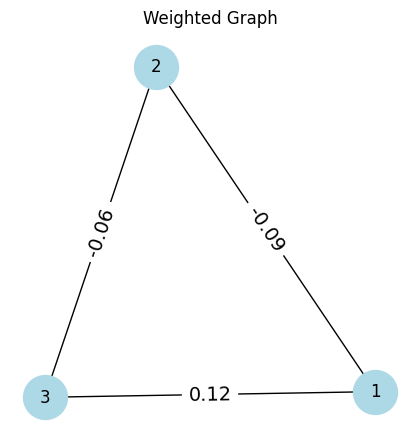

In [23]:
plt.figure(figsize=(4,4))
G = nx.Graph()

for (u, v), weight in edge_dict.items():
    G.add_edge(u, v, weight=weight)

# Create a fixed layout for the graph
pos = nx.spring_layout(G, seed=111)  # Set a seed for reproducibility

# Draw the graph
nx.draw(G, pos, with_labels=True, node_color="lightblue", node_size=1000)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=14)
plt.title("Weighted Graph")
plt.show()

# Formulate the QUBO (Quadratic Unconstrained Binary Optimization) Problem

The MinCut problem can be written as:
$$
\text{Objective: } \min_x \sum_{i,j} w_{ij} x_i (1 - x_j)
$$

In [24]:
n = adjacency_matrix.shape[0]
x = symbols(f"x1:{n+1}")

for i in range(n):
    for j in range(n):
        display(adjacency_matrix[i, j] * x[i] * (1 - x[j]))

qubo_expr = sum([adjacency_matrix[i, j] * x[i] * (1 - x[j]) for i in range(n) for j in range(n)])

qubo_expr

0

-0.09*x1*(1 - x2)

0.12*x1*(1 - x3)

-0.09*x2*(1 - x1)

0

-0.06*x2*(1 - x3)

0.12*x3*(1 - x1)

-0.06*x3*(1 - x2)

0

-0.09*x1*(1 - x2) + 0.12*x1*(1 - x3) - 0.09*x2*(1 - x1) - 0.06*x2*(1 - x3) + 0.12*x3*(1 - x1) - 0.06*x3*(1 - x2)

In [25]:
simplified_qubo = simplify(qubo_expr)
simplified_qubo

0.18*x1*x2 - 0.24*x1*x3 + 0.03*x1 + 0.12*x2*x3 - 0.15*x2 + 0.06*x3

In [ ]:
x1, x2 = symbols('x1 x2')
term = 0.18 * x1 * x2

# term.coeff()



C:\Users\mysore\AppData\Local\Temp\ipykernel_23316\3879434579.py:6: SymPyDeprecationWarning: 

Using non-Expr arguments in Mul is deprecated (in this case, one of
the arguments has type 'FiniteSet').

If you really did intend to use a multiplication or addition operation with
this object, use the * or + operator instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#non-expr-args-deprecated
for details.

This has been deprecated since SymPy version 1.7. It
will be removed in a future version of SymPy.

  Mul(term.free_symbols)


{x1, x2}

In [62]:
from sympy import symbols

# Define the variables
x1, x2 = symbols('x1 x2')

# Example term
term = 0.18 * x1 * x2

# Extract the coefficient of the specific term (x1 * x2)
coefficient = term.coeff(Mul(*(term.free_symbols)))

print("Term:", term)
print("Coefficient:", coefficient)


Term: 0.18*x1*x2
Coefficient: 0.180000000000000


In [65]:
# Extract coefficients for QUBO matrix
Q = Matrix.zeros(n, n)
for term in simplified_qubo.as_ordered_terms():
    variables = term.free_symbols
    coeff = term.coeff(Mul(*(variables)))
    if len(variables) == 1:  # Diagonal terms (linear coefficients)
        var = list(variables)[0]
        idx = int(str(var)[1:]) - 1
        Q[idx, idx] += coeff
    elif len(variables) == 2:  # Off-diagonal terms (quadratic coefficients)
        var1, var2 = sorted(variables, key=lambda v: int(str(v)[1:]))
        idx1, idx2 = int(str(var1)[1:]) - 1, int(str(var2)[1:]) - 1
        Q[idx1, idx2] += coeff # Account for symmetry
        Q[idx2, idx1] += coeff
Q

Matrix([
[ 0.03,  0.18, -0.24],
[ 0.18, -0.15,  0.12],
[-0.24,  0.12,  0.06]])

# Solving the QUBO Problem

The goal is to find a binary vector $x$ such that:
$$
\min_x\ x^T Q x
$$

We will evaluate all possible binary vectors $ x $ (for small problem sizes) and compute the cost function value for each.


In [66]:
n = Q.shape[0]
x_symbols = symbols(f"x1:{n+1}")
all_possible_vectors = [Matrix([int(b) for b in f"{i:0{n}b}"]) for i in range(2**n)]
min_cost = float('inf')
optimal_vector = None
for x in all_possible_vectors:
    cost = (x.T * Q * x)[0]  # Evaluate cost function
    print(x, cost)
    if cost < min_cost:
        min_cost = cost
        optimal_vector = x

Matrix([[0], [0], [0]]) 0
Matrix([[0], [0], [1]]) 0.0600000000000000
Matrix([[0], [1], [0]]) -0.150000000000000
Matrix([[0], [1], [1]]) 0.150000000000000
Matrix([[1], [0], [0]]) 0.0300000000000000
Matrix([[1], [0], [1]]) -0.390000000000000
Matrix([[1], [1], [0]]) 0.240000000000000
Matrix([[1], [1], [1]]) 0.0600000000000000


In [67]:
optimal_vector, min_cost

(Matrix([
 [1],
 [0],
 [1]]),
 -0.390000000000000)

# Visualization of the Optimal Cut

The optimal binary vector partitions the graph into two sets:
- Nodes with $ x_i = 0 $
- Nodes with $ x_i = 1 $

We can highlight the edges in the cut using different colors.


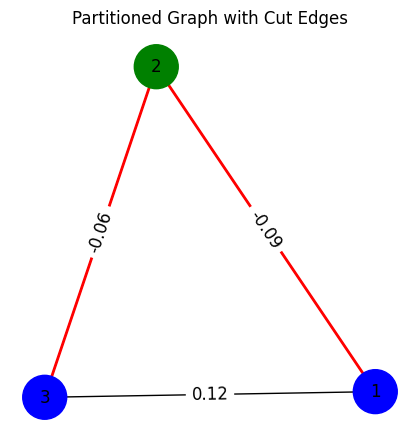

In [68]:
# Identify nodes in each partition
partition_0 = [i + 1 for i, val in enumerate(optimal_vector) if val == 0]
partition_1 = [i + 1 for i, val in enumerate(optimal_vector) if val == 1]

# Assign colors to nodes based on partition
node_colors = []
for node in G.nodes:
    if node in partition_0:
        node_colors.append("green")  # Nodes in partition 0
    elif node in partition_1:
        node_colors.append("blue")   # Nodes in partition 1

# Highlight the edges in the cut
cut_edges = [(u, v) for u, v in G.edges if (u in partition_0 and v in partition_1) or (u in partition_1 and v in partition_0)]

# Plot the graph with node colors and cut edges
plt.figure(figsize=(4, 4))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000)
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, edge_color="red", width=2)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=12)
plt.title("Partitioned Graph with Cut Edges")
plt.show()


In [69]:
from pyqubo import Array, solve_qubo
import numpy as np

In [70]:
# Create binary variables
x = Array.create('x', shape=Q.shape[0], vartype='BINARY')

# Formulate the QUBO model
qubo_model = sum(Q[i, j] * x[i] * x[j] for i in range(Q.shape[0]) for j in range(Q.shape[1]))
qubo_model = qubo_model.compile()

# Generate the QUBO dictionary
qubo, offset = qubo_model.to_qubo()

# Solve the QUBO problem using the default solver
solution = solve_qubo(qubo)

# Extract results
optimal_solution = np.array([solution[f'x[{i}]'] for i in range(Q.shape[0])])
print("Optimal solution (binary vector):", optimal_solution)
print("Optimal cost:", sum(Q[i, j] * optimal_solution[i] * optimal_solution[j] for i in range(Q.shape[0]) for j in range(Q.shape[1])))

Optimal solution (binary vector): [1 0 1]
Optimal cost: -0.390000000000000


C:\Users\mysore\AppData\Local\Temp\ipykernel_23316\229288507.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) solve_qubo. (You should use simulated annealing sampler of dwave-neal directly.) -- Deprecated since version 0.4.0.
  solution = solve_qubo(qubo)


In [73]:
import gurobipy as gp
from gurobipy import GRB

In [74]:
# Initialize Gurobi model
model = gp.Model("QUBO")

# Create binary variables
n = Q.shape[0]
x = model.addVars(n, vtype=GRB.BINARY, name="x")

# Add the objective function
objective = gp.QuadExpr()
for i in range(n):
    for j in range(n):
        objective += Q[i, j] * x[i] * x[j]

model.setObjective(objective, GRB.MINIMIZE)

# Optimize the model
model.optimize()

# Extract the optimal solution
optimal_solution = np.array([x[i].x for i in range(n)])
print("Optimal solution (binary vector):", optimal_solution)
print("Optimal cost:", model.objVal)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-12800H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 0 rows, 3 columns and 0 nonzeros
Model fingerprint: 0x715c56e5
Model has 6 quadratic objective terms
Variable types: 0 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Found heuristic solution: objective -0.3900000
Presolve removed 0 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 20 available processors)

Solution count 2: -0.39 0 

Optimal solution found (tolerance 1.00e-04)
B